In [ ]:
# Generate the binary demo just with two views

# -- Load the original demo generation script

# Decide on the best visualization for multiclass segmentation

# Do it well -- videos can be submitted as a supplimentary material later on



binary.ipynb             hard_example_demo.mp4
hard_example_demo_2.mp4  output_frames/
hard_example_demo_3.mp4  resnet_18_8s_best.pth
hard_example_demo_4.mp4  resnet_18_8s_multiclass_best.pth
hard_example_demo_5.mp4


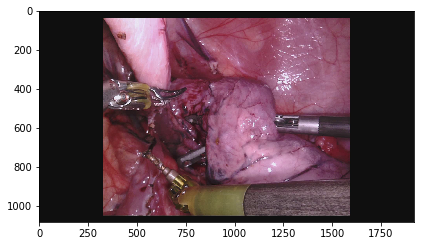

In [1]:
%matplotlib inline

import imageio
import skimage.io as io
import numpy as np

images_video_filename = '/home/daniil/projects/endovis/baba.avi'

# Creating readers for each of our videos
images_reader = imageio.get_reader(images_video_filename, 'ffmpeg')

current_dataset_number_of_images = images_reader.get_length()

index = 300

current_image = np.asarray(images_reader.get_data(index))

io.imshow(current_image)

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


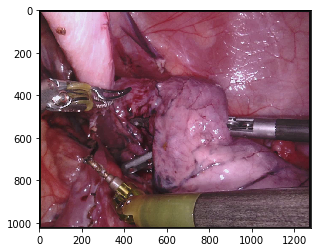

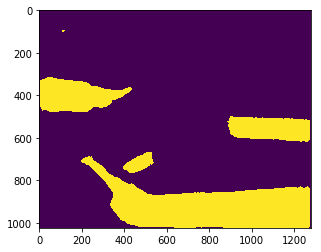

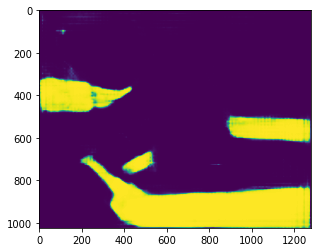

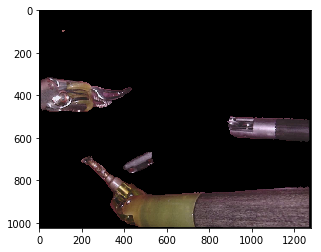

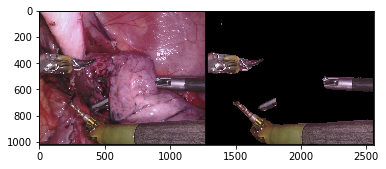

In [8]:
import sys, os
sys.path.append("/home/daniil/repos/pytorch-segmentation-detection/")
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

import numpy as np


img_path = '/home/daniil/projects/endovis/dataset/instrument_dataset_9/left_frames/frame050.png'


valid_transform = transforms.Compose(
                [
                     transforms.CenterCrop((1024, 1280)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ])

just_crop_transform = transforms.CenterCrop((1024, 1280))

fcn = resnet_dilated.Resnet18_8s(num_classes=2)
fcn.load_state_dict(torch.load('resnet_18_8s_best.pth'))
fcn.cuda()
fcn.eval()

#current_image = Image.open(img_path)


img_not_preprocessed = Image.fromarray(current_image).convert('RGB')
#img_not_preprocessed = current_image.convert('RGB')#.resize((512, 512))

current_img_crop = np.asarray(just_crop_transform(img_not_preprocessed))

img = valid_transform(img_not_preprocessed)

img = img.unsqueeze(0)

img = Variable(img.cuda())

res = fcn(img)

soft_labels = torch.nn.functional.softmax(res).squeeze(0)

_, hard_labels = res.squeeze(0).max(0)

segmentation = hard_labels.data.cpu().numpy().squeeze()
soft_mask = soft_labels.data.cpu().numpy()[1, :, :]

hard_masked_out_instrument = current_img_crop * np.expand_dims(segmentation, 2).astype(np.uint8)

soft_masked_out_instrument = (((current_img_crop.astype(np.float32) / 255) * np.expand_dims(soft_mask, 2)) * 255).astype(np.uint8)

double_view = np.zeros((1024, 1280*2, 3), np.uint8)

double_view[:1024, :1280, :] = current_img_crop
double_view[:1024, 1280:, :] = hard_masked_out_instrument


plt.imshow(current_img_crop)
plt.show()

plt.imshow(segmentation)
plt.show()

plt.imshow(soft_mask)
plt.show()

plt.imshow(hard_masked_out_instrument)
plt.show()

plt.imshow(double_view)
plt.show()

In [119]:
save_file_template = 'output_frames/{0:08d}.png'

for index in xrange(1000):

    current_image = np.asarray(images_reader.get_data(index))
    
    img_not_preprocessed = Image.fromarray(current_image).convert('RGB')#.resize((512, 512))

    current_img_crop = np.asarray(just_crop_transform(img_not_preprocessed))

    img = valid_transform(img_not_preprocessed)

    img = img.unsqueeze(0)

    img = Variable(img.cuda())

    res = fcn(img)

    soft_labels = torch.nn.functional.softmax(res).squeeze(0)

    _, hard_labels = res.squeeze(0).max(0)

    segmentation = hard_labels.data.cpu().numpy().squeeze()
    soft_mask = soft_labels.data.cpu().numpy()[1, :, :]

    hard_masked_out_instrument = current_img_crop * np.expand_dims(segmentation, 2).astype(np.uint8)

    soft_masked_out_instrument = (((current_img_crop.astype(np.float32) / 255) * np.expand_dims(soft_mask, 2)) * 255).astype(np.uint8)

    double_view = np.zeros((1024, 1280*2, 3), np.uint8)

    double_view[:1024, :1280, :] = current_img_crop
    double_view[:1024, 1280:, :] = soft_masked_out_instrument

    image_filename_to_save = save_file_template.format(index)
    
    plt.imsave(image_filename_to_save, double_view)
    
    print(image_filename_to_save)

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


output_frames/00000000.png
output_frames/00000001.png
output_frames/00000002.png
output_frames/00000003.png
output_frames/00000004.png
output_frames/00000005.png
output_frames/00000006.png
output_frames/00000007.png
output_frames/00000008.png
output_frames/00000009.png
output_frames/00000010.png
output_frames/00000011.png
output_frames/00000012.png
output_frames/00000013.png
output_frames/00000014.png
output_frames/00000015.png
output_frames/00000016.png
output_frames/00000017.png
output_frames/00000018.png
output_frames/00000019.png
output_frames/00000020.png
output_frames/00000021.png
output_frames/00000022.png
output_frames/00000023.png
output_frames/00000024.png
output_frames/00000025.png
output_frames/00000026.png
output_frames/00000027.png
output_frames/00000028.png
output_frames/00000029.png
output_frames/00000030.png
output_frames/00000031.png
output_frames/00000032.png
output_frames/00000033.png
output_frames/00000034.png
output_frames/00000035.png
output_frames/00000036.png
o

output_frames/00000304.png
output_frames/00000305.png
output_frames/00000306.png
output_frames/00000307.png
output_frames/00000308.png
output_frames/00000309.png
output_frames/00000310.png
output_frames/00000311.png
output_frames/00000312.png
output_frames/00000313.png
output_frames/00000314.png
output_frames/00000315.png
output_frames/00000316.png
output_frames/00000317.png
output_frames/00000318.png
output_frames/00000319.png
output_frames/00000320.png
output_frames/00000321.png
output_frames/00000322.png
output_frames/00000323.png
output_frames/00000324.png
output_frames/00000325.png
output_frames/00000326.png
output_frames/00000327.png
output_frames/00000328.png
output_frames/00000329.png
output_frames/00000330.png
output_frames/00000331.png
output_frames/00000332.png
output_frames/00000333.png
output_frames/00000334.png
output_frames/00000335.png
output_frames/00000336.png
output_frames/00000337.png
output_frames/00000338.png
output_frames/00000339.png
output_frames/00000340.png
o

output_frames/00000608.png
output_frames/00000609.png
output_frames/00000610.png
output_frames/00000611.png
output_frames/00000612.png
output_frames/00000613.png
output_frames/00000614.png
output_frames/00000615.png
output_frames/00000616.png
output_frames/00000617.png
output_frames/00000618.png
output_frames/00000619.png
output_frames/00000620.png
output_frames/00000621.png
output_frames/00000622.png
output_frames/00000623.png
output_frames/00000624.png
output_frames/00000625.png
output_frames/00000626.png
output_frames/00000627.png
output_frames/00000628.png
output_frames/00000629.png
output_frames/00000630.png
output_frames/00000631.png
output_frames/00000632.png
output_frames/00000633.png
output_frames/00000634.png
output_frames/00000635.png
output_frames/00000636.png
output_frames/00000637.png
output_frames/00000638.png
output_frames/00000639.png
output_frames/00000640.png
output_frames/00000641.png
output_frames/00000642.png
output_frames/00000643.png
output_frames/00000644.png
o

output_frames/00000912.png
output_frames/00000913.png
output_frames/00000914.png
output_frames/00000915.png
output_frames/00000916.png
output_frames/00000917.png
output_frames/00000918.png
output_frames/00000919.png
output_frames/00000920.png
output_frames/00000921.png
output_frames/00000922.png
output_frames/00000923.png
output_frames/00000924.png
output_frames/00000925.png
output_frames/00000926.png
output_frames/00000927.png
output_frames/00000928.png
output_frames/00000929.png
output_frames/00000930.png
output_frames/00000931.png
output_frames/00000932.png
output_frames/00000933.png
output_frames/00000934.png
output_frames/00000935.png
output_frames/00000936.png
output_frames/00000937.png
output_frames/00000938.png
output_frames/00000939.png
output_frames/00000940.png
output_frames/00000941.png
output_frames/00000942.png
output_frames/00000943.png
output_frames/00000944.png
output_frames/00000945.png
output_frames/00000946.png
output_frames/00000947.png
output_frames/00000948.png
o

In [120]:
fps = 25

writer = imageio.get_writer('hard_example_demo_5.mp4', fps=fps)

for index in xrange(1000):
    
    image_filename_to_read = save_file_template.format(index)

    img = io.imread(image_filename_to_read)
    
    writer.append_data(img)

writer.close()